**Ejercicio Práctico - Clase 3 VPC2 - 4Co2021**

1) Realizar transfer learning a partir de alguna de las siguientes redes: vgg11, resnet18, convnext_tiny preentrenadas, y entrenar sobre el dataset CIFAR10 contenido en PyTorch. Que puede concluir al compararlos con los resultados obtenidos en el entrenamiento de la tarea 2?

2) Realice el entrenamiento de la misma red seleccionada en el punto 1, sin partir de pesos preentrenados en esta oportunidad y sin congelar capas. A que resultados llega y como los explica?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchsummary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [21]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [2]:
!pip install torchmetrics
import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 3.4 MB/s 


**Se visualizan los datos del dataset CIFAR10**


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
### Descripción del conjunto de entrenamiento ###
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
### Dimensiones de un ejemplo del dataset ###
(32, 32, 3)
### Descripción del conjunto de evaluación ###
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Label de la imágen 0: 6
Label de la imágen 1: 9
Label de la imágen 2: 9
Label de la imágen 3: 4
Label de la imágen 4: 1
Label de la imágen 5: 1
Label de la imágen 6: 2
Label de la imágen 7: 7
Label de la imágen 8: 8


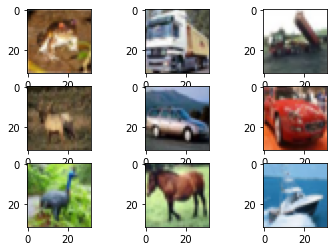

In [3]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

print("### Descripción del conjunto de entrenamiento ###")
print(train_set)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_set[0][0]))
print("### Descripción del conjunto de evaluación ###")
print(test_set)

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_set[i]
  plt.subplot(331 + i)
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, label))

plt.show()

**Carga de datos con ImageDataGenerator**

In [4]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Resize((224, 224)),
                    torchvision.transforms.RandomHorizontalFlip(0.5),
                    torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  ])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
valid_set_size = 5000

train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


In [15]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=12, shuffle=True, num_workers=8)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=12, shuffle=True, num_workers=8)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Carga de modelo base**

In [16]:
#MODELO BASE
resnet18_model = torchvision.models.resnet18(pretrained=True) #load resnet18 model
resnet18_model.to("cuda")

#resnet18_model= resnet18_model.to(device)
torchsummary.summary(resnet18_model, input_size=(3, 32, 32))
resnet18_model.modules




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

**Congelo las capas de la red base**

In [17]:
for param in resnet18_model.parameters():
    param.requires_grad = False

In [18]:
num_features = resnet18_model.fc.in_features     #extract fc layers features
resnet18_model.fc = torch.nn.Linear(num_features, 10) #(num_of_class == 10)

In [19]:
optimizer_ft = torch.optim.SGD(resnet18_model.parameters(), lr=0.0001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() #(set loss function)

In [20]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [22]:
result_model, history = train(resnet18_model, criterion, optimizer_ft, train_loader, valid_loader, 20)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/20 - Train loss 1.311106 - Train Accuracy 0.602089 - Valid Loss 0.861701 - Valid Accuracy 0.726019
Epoch: 2/20 - Train loss 0.914573 - Train Accuracy 0.710311 - Valid Loss 0.736683 - Valid Accuracy 0.758593
Epoch: 3/20 - Train loss 0.837615 - Train Accuracy 0.724822 - Valid Loss 0.684442 - Valid Accuracy 0.770983
Epoch: 4/20 - Train loss 0.796740 - Train Accuracy 0.734956 - Valid Loss 0.668084 - Valid Accuracy 0.771783
Epoch: 5/20 - Train loss 0.779641 - Train Accuracy 0.735378 - Valid Loss 0.635735 - Valid Accuracy 0.785671
Epoch: 6/20 - Train loss 0.761970 - Train Accuracy 0.744467 - Valid Loss 0.628728 - Valid Accuracy 0.789269
Epoch: 7/20 - Train loss 0.751543 - Train Accuracy 0.743711 - Valid Loss 0.623265 - Valid Accuracy 0.795364
Epoch: 8/20 - Train loss 0.744227 - Train Accuracy 0.748289 - Valid Loss 0.625828 - Valid Accuracy 0.791867
Epoch: 9/20 - Train loss 0.739036 - Train Accuracy 0.747133 - Valid Loss 0.635836 - Valid Accuracy 0.780875
Epoch: 10/20 - Train loss 0.

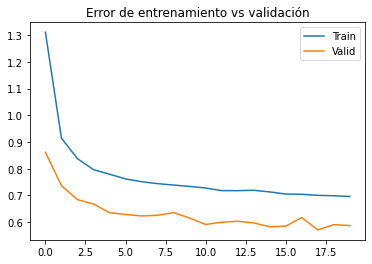

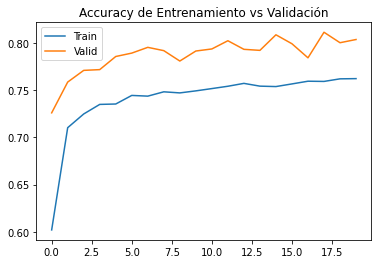

In [23]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

plt.plot(history["train_acc"])
plt.plot(history["valid_acc"])
plt.title("Accuracy de Entrenamiento vs Validación")
plt.legend(['Train', 'Valid'])
plt.show()

Se puede observar que para los datos de validacion se obtuvieron mejores resultados que con el modelo entrenado en la clase 2, tanto a nivel de accuracy como a nivel de error



**Trabajo sin congelar capas**

In [26]:
resnet18_model_1 = torchvision.models.resnet18(pretrained=False)
resnet18_model_1.to("cuda")
torchsummary.summary(resnet18_model_1, input_size=(3, 32, 32))
resnet18_model_1.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [27]:
num_features_1 = resnet18_model_1.fc.in_features     #extract fc layers features
resnet18_model_1.fc = torch.nn.Linear(num_features_1, 10) #(num_of_class == 10)

In [28]:
optimizer_ft_2 = torch.optim.SGD(resnet18_model_1.parameters(), lr=0.0001, momentum=0.9)
criterion_2 = torch.nn.CrossEntropyLoss()#(set loss function)


In [29]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [ ]:
result_model_2, history = train(resnet18_model_1, criterion_2, optimizer_ft_2, train_loader, valid_loader, 20)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/20 - Train loss 1.876857 - Train Accuracy 0.305578 - Valid Loss 1.637487 - Valid Accuracy 0.390887
Epoch: 2/20 - Train loss 1.587214 - Train Accuracy 0.420289 - Valid Loss 1.459502 - Valid Accuracy 0.466827
Epoch: 3/20 - Train loss 1.439436 - Train Accuracy 0.479933 - Valid Loss 1.337584 - Valid Accuracy 0.522482
Epoch: 4/20 - Train loss 1.328517 - Train Accuracy 0.522222 - Valid Loss 1.202712 - Valid Accuracy 0.571143
Epoch: 5/20 - Train loss 1.230746 - Train Accuracy 0.561756 - Valid Loss 1.097596 - Valid Accuracy 0.609512
Epoch: 6/20 - Train loss 1.155199 - Train Accuracy 0.590667 - Valid Loss 1.038570 - Valid Accuracy 0.627298
Epoch: 7/20 - Train loss 1.082510 - Train Accuracy 0.617622 - Valid Loss 0.983247 - Valid Accuracy 0.649380
Epoch: 8/20 - Train loss 1.025059 - Train Accuracy 0.639200 - Valid Loss 0.928371 - Valid Accuracy 0.670164
Epoch: 9/20 - Train loss 0.972563 - Train Accuracy 0.658467 - Valid Loss 0.877736 - Valid Accuracy 0.689848
Epoch: 10/20 - Train loss 0.

In [1]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

plt.plot(history["train_acc"])
plt.plot(history["valid_acc"])
plt.title("Accuracy de Entrenamiento vs Validación")
plt.legend(['Train', 'Valid'])
plt.show()

NameError: ignored